# Tutorial 2: SPOTS (Mouse Spleen dataset)

DePass was applied to the mouse spleen SPOTS dataset (2,568 spatial spots) for cross-modal integration and data enhancement. This tutorial demonstrates: 
1. Spatial domain identification in mouse spleen tissue using DePass.
2. Validation of data enhancement through comparative analysis of biomarker log2 fold-changes (LogFC) and spatial expression patterns.
3. In addition, we calculated the Pearson Correlation Coefficient (PCC) between genes and proteins associated with the biomarkers, confirming that the enhanced data retained biological consistency.

### Preparation

In [20]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('/home/jyx/DePass/')

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'
 
path = '../data/dataset_MouseSpleen'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '../data/dataset_MouseSpleen' already exists.



### Loading and preprocessing

In [2]:
adata_omics1 = sc.read_h5ad('/data/jyx/data/dataset_MouseSpleen/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('/data/jyx/data/dataset_MouseSpleen/adata_ADT.h5ad')

gene = [
'Cd3g','Cd3d','Cd3e',  
'Cd4', 
'Cd8a',
'Cd19',
'Ighd',
'Cd163'
]

preprocess_data(adata=adata_omics1,modality='rna',gene_list=gene)
preprocess_data(adata=adata_omics2,modality='protein')
adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}


### Training the model

The DePass model is designed for multi-omics data integration at both spatial and single-cell data. After training, the output file includes the following key results:

1. **`embedding`**: Integrated embedding representation, which integrates multi-omics expression features with spatial coordinate information (for spatial data). This representation is used directly for downstream tasks (e.g., spatial domain segmentation) or visualization (e.g., UMAP). 
2. **`x1_enh`**: Enhanced feature matrix for the first omics modality.  
3. **`x2_enh`**: Enhanced feature matrix for the second omics modality.  
4. **`alpha`**: Cross-modality attention weight matrix, dynamically learned through a attention mechanism. It reflects the relative importance of each modality in clustering units (e.g., cells/spots/bins).

In [3]:
from DePass.model import DePass
model = DePass(data, data_type='spatial',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:02<00:00, 96.71it/s] 

Model training finished!



In [4]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh
adata.obsm['x2_enh'] = model.x2_enh

### Detect spatial domain 

In [5]:
from DePass.utils import *
clustering(adata=adata,n_clusters=3,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


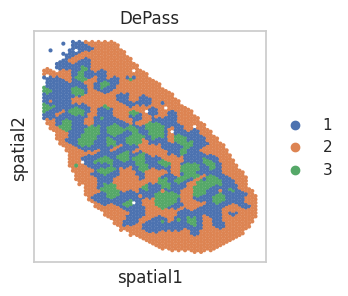

In [23]:
from DePass.analyze_utils import plot_spatial

plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=35,
    show=True,
)

### Data enhancement analysis: marker LogFC and expression pattern


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate log-fold change (logFC) values. 



In [ ]:
import anndata as ad
# Create two AnnData objects to store the raw and enhanced data. 
adata1_high = adata_omics1[:,adata_omics1.var['highly_variable_all']]

adata1_R = ad.AnnData(X=adata1_high.obsm['X_norm'], obs=adata.obs[['DePass']].copy(), var=adata1_high.var.copy(), obsm={'spatial': adata1_high.obsm['spatial'].copy()})
adata1_E = ad.AnnData(X=adata.obsm['x1_enh'], obs=adata.obs[['DePass']].copy(), var=adata1_high.var.copy(), obsm={'spatial': adata1_high.obsm['spatial'].copy()})
adata2_R = ad.AnnData(X=adata_omics2.obsm['X_clr'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E = ad.AnnData(X=adata.obsm['x2_enh'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})

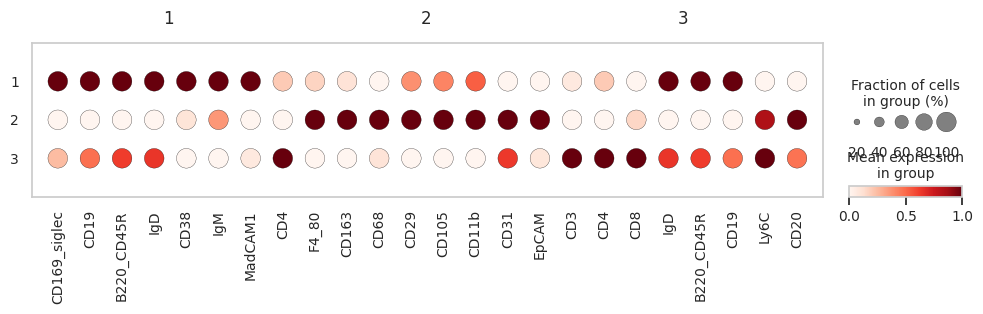

In [25]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata1_R, save_path=path, groupby='DePass', figname='rank_x1_R', figsize=(12,2), n_genes=8,show=False)
rank_genes_groups(adata=adata1_E, save_path=path, groupby='DePass', figname='rank_x1_E', figsize=(12,2), n_genes=8,show=False)
rank_genes_groups(adata=adata2_R, save_path=path, groupby='DePass', figname='rank_x2_R', figsize=(12,2), n_genes=8,show=True)
rank_genes_groups(adata=adata2_E, save_path=path, groupby='DePass', figname='rank_x2_E', figsize=(12,2), n_genes=8,show=False)

In [ ]:
adata1_R.write(path+'/adata1_R.h5ad')
adata1_E.write(path+'/adata1_E.h5ad')
adata2_R.write(path+'/adata2_R.h5ad')
adata2_E.write(path+'/adata2_E.h5ad')

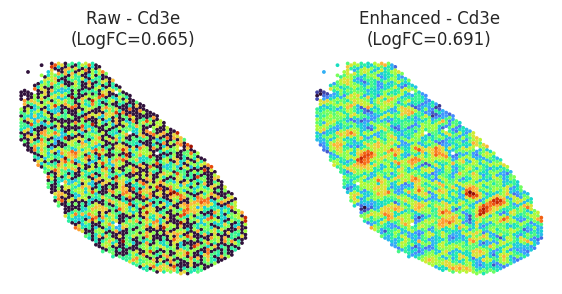

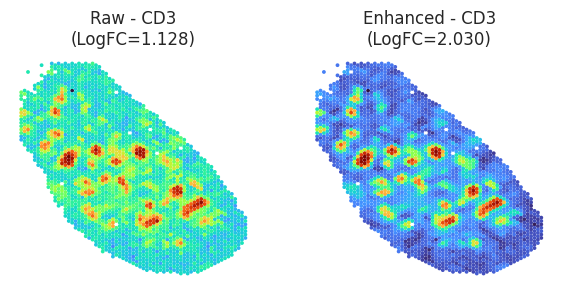

In [26]:
from DePass.analyze_utils import *
plot_marker_comparison_with_logFC(adata1_R, adata1_E, target_gene='Cd3e', target_group='3', save_path=path, save_name='Cd3e', s=30,show=True)
plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='CD3', target_group='3', save_path=path, save_name='CD3', s=30,show=True)

## PCC comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

gene_adt_mapping = {
    "CD3": ["Cd3g", "Cd3d", "Cd3e"],
    "CD4": ["Cd4"],
    "CD8": ["Cd8a"],
    "CD19": ["Cd19"],
    "IgD": ["Ighd"],
    "CD163": ["Cd163"]
}

from DePass.analyze_utils import calculate_correlation
df_raw_pcc = calculate_correlation(adata1_R, adata2_R, gene_adt_mapping)
df_raw_pcc['type'] = 'Raw'  
df_enh_pcc = calculate_correlation(adata1_E, adata2_E, gene_adt_mapping)
df_enh_pcc['type'] = 'Enh' 
df_combined = pd.concat([df_raw_pcc, df_enh_pcc])
df_combined.to_csv(path + "/PCC.csv", sep='\t',index=False)

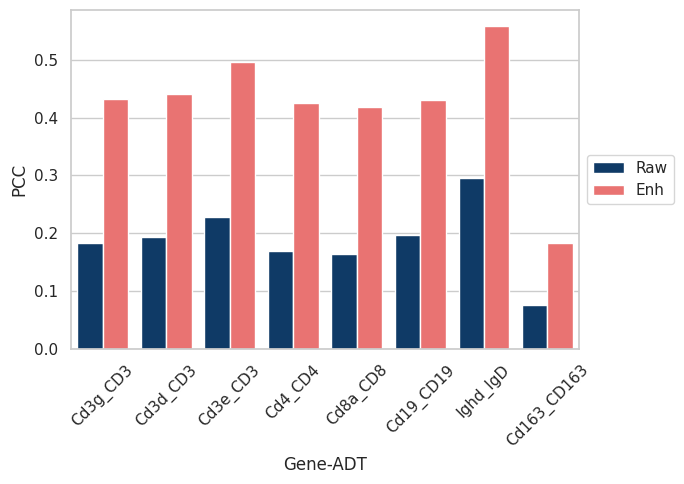

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_palette = ["#003A75","#FD5F5E", "#345D82"]
sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x="Gene_ADT",
    y="Correlation",
    hue="type",
    data=df_combined,
    palette=custom_palette
)
plt.xlabel("Gene-ADT")
plt.ylabel("PCC")
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.tight_layout()
plt.savefig(path+"/PCC Comparison (Raw vs Augmented).png", dpi=300)
plt.show()